**Trabajo personal**

*Santiago Lamas Fresard*

In [255]:
using JuMP, SDDP, Ipopt, Gurobi, LinearAlgebra, Distributions, Random, Plots

const GRB_ENV = Gurobi.Env()

Set parameter Username
Set parameter LicenseID to value 2760931
Academic license - for non-commercial use only - expires 2027-01-05


Gurobi.Env(Ptr{Nothing} @0x000002452a5558b0, false, 0)

# **Modelos**

## **Código MultiagedForests.jl**

*Single-species, multiaged forest model, taken from "A Discussion of Vintage Optimization Models in Forest Economics", A. Piazza, Forest Science, Vol 66(4) pp.469-477, 2020.*

In [256]:
# Entrega el conjunto de operadores soportados para expresiones no lineales.
# print(MOI.get(Ipopt.Optimizer(), MOI.ListOfSupportedNonlinearOperators()))

In [257]:
UB = 1000 # upper bound for the objective function
b = 0.975 # discount factor used by Buongiorno
α = 0.5 # risk aversion parameter for the utility function
n = 5 # number of age classes
f = [0.8, 4.2, 16.99, 68.1, 84] # biomass coeffcients
x0 = [1.0, 0.0, 0.0, 0.0, 0.0] # initial state

5-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0

In [258]:
# Creamos un gráfico cíclico de un nodo con probablidad (1-b) de salir del ciclo 
graph = SDDP.UnicyclicGraph(b; num_nodes = 1)

Root
 0
Nodes
 1
Arcs
 0 => 1 w.p. 1.0
 1 => 1 w.p. 0.975

## **Estimación de la función de costos**

En primer lugar se aproxima la función objetivo mediante una función cuadrática: se busca aquella función $x\mapsto ax^2 + bx +c$ que minimice 
$$
\int_0^T \left( \frac{x^{1-\alpha}}{1-\alpha} - (ax^2 + bx +c) \right)^2 dx
$$
el criterio de primer orden entrega que los parámetros óptimos son
$$
\begin{pmatrix} a \\ b \\ c \end{pmatrix} = \frac{1}{1-\alpha}
\begin{pmatrix} 
\frac{T^5}5 & \frac{T^4}4 & \frac{T^3}3 \\
\frac{T^4}4 & \frac{T^3}3 & \frac{T^2}2 \\
\frac{T^3}3 & \frac{T^2}2 & T \\
\end{pmatrix}^{-1}
\begin{pmatrix}
\frac{T^{4-\alpha}}{4-\alpha} \\ \frac{T^{3-\alpha}}{3-\alpha} \\ \frac{T^{2-\alpha}}{2-\alpha} 
\end{pmatrix}
$$

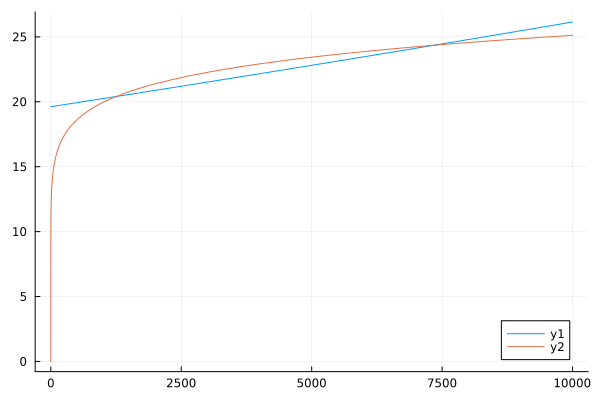

In [259]:
# Aproximación mediante una función cuadrática.

function optimal_params(α, T)
    A = [T^5/5 T^4/4 T^3/3; T^4/4 T^3/3 T^2/2; T^3/3 T^2/2 T]
    b = [T^(4-α)/(4-α); T^(3-α)/(3-α); T^(2-α)/(2-α)]/(1-α)
    return A^-1*b
end

a_ej, b_ej, c_ej = optimal_params(0.9, 10000)

function quad_ej(x)
    return a_ej*x^2 + b_ej*x + c_ej
end

function raiz_ej(x)
    return x^(1-9/10)/((1-9/10))
end

plot(quad_ej, 0,10000)
plot!(raiz_ej, 0, 10000)

Lo siguiente fue aproximar superiormente la función objetivo: dada una colección de puntos $\{x_i\}_{i=1}^N$, se calculan las rectas tangentes a la función objetivo en dichos puntos:
$$
a_i x + b_i,\quad a_i = f'(x_i),\, a_i x_i + b_i = f(x_i) \Rightarrow b_i = f(x_i) - a_i x_i,
$$
y se hace la transformación del problema
$$
\max_{TV}\quad f(TV) \\
\text{s.a.}\quad TV\in C
$$
equivalente a 
$$
\max_{u}\quad u \\
\text{s.a.}\quad u\leq f(TV) \\ 
\quad TV\in C
$$


por la siguiente aproximación
$$
\max_{u}\quad u \\
\text{s.a.}\quad u\leq a_i TV + b_i,\, i=1,\ldots, N \\ 
\quad TV\in C
$$

La otra forma de realizar esto fue aproximando inferiormente la función, utilizando las rectas $x\mapsto a_i x + b_i = \frac{f(x_{i+1}) - f(x_i)}{x_{i+1} - x_i}(x - x_i) + f(x_i)$

In [352]:
nx = 2500
dx = 250000/nx
ny = 200
dy = 1000/ny

# Aproximación linear por trozos
function approx_linear(x)
  i_dx = floor(x/dx)
  dy = sqrt((i_dx +1)*dx) - sqrt(i_dx*dx)
  return dy/dx * (x - i_dx*dx) + sqrt(i_dx*dx)
end

# Aproximación por una función cuadrática
a, b, c = optimal_params(α, UB^2/4)
function approx_quad(x)
  return a*x^2 + b*x + c
end

function obj(x)
  return x^(1-α)/(1-α)
end

function deriv_obj(x)
  return x^-α
end

function inv_obj(y)
  return ((1-α)*y)^(1/(1-α))
end

d_unif_x = 1:dx:250000
d_unif_y = 1:dy:1000

f_unif_x = obj.(d_unif_x)
f_inv_y = inv_obj.(d_unif_y)

# Aproximación mediante tangentes:
# eje x
as1_x = deriv_obj.(d_unif_x)
bs1_x = f_unif_x .- as1_x .* d_unif_x
# eje y
as1_y = deriv_obj.(f_inv_y)
bs1_y = d_unif_y .- as1_y .* f_inv_y 

# Aproximación mediante interpolación lineal:
# eje x
as2_x = [(f_unif_x[i+1] - f_unif_x[i])/dx for i in 1:nx-1]
bs2_x = f_unif_x[1:nx-1] .- as2_x .* d_unif_x[1:nx-1]
# eje y
as2_y = [dy/(f_inv_y[i+1] - f_inv_y[i]) for i in 1:ny-1]
bs2_y = d_unif_y[1:ny-1] .- as2_y .* f_inv_y[1:ny-1]

199-element Vector{Float64}:
   0.8571428571428572
   3.8823529411764706
   6.518518518518519
   9.08108108108108
  11.617021276595745
  14.140350877192983
  16.65671641791045
  19.16883116883117
  21.67816091954023
  24.185567010309278
  26.69158878504673
  29.196581196581192
  31.700787401574804
   ⋮
 469.2466702184337
 471.7466878643349
 474.24670532419606
 476.7467226009439
 479.24673969744396
 481.74675661650235
 484.2467733608673
 486.7467899332306
 489.2468063362289
 491.74682257244535
 494.24683864441073
 496.74685455460497

## **Prueba de modelos**

Función cuadrática

In [261]:
model0 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
    end)
    @stageobjective(sp, approx_quad(TV))
    #@stageobjective(sp, TV^(1-α)/(1-α)) # CRRA objective function
    #@stageobjective(sp, log(TV)) # Logarithmic objective function
end

A policy graph with 1 nodes.
 Node indices: 1


Método de la tangente uniforme en x

In [262]:
model1 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1:nx], u <= as1_x[s]*TV + bs1_x[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
    #@stageobjective(sp, TV^(1-α)/(1-α)) # CRRA objective function
    #@stageobjective(sp, log(TV)) # Logarithmic objective function
end

A policy graph with 1 nodes.
 Node indices: 1


Método de la tangente uniforme en y

In [263]:
model2 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1:ny], u <= as1_y[s]*TV + bs1_y[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
    #@stageobjective(sp, TV^(1-α)/(1-α)) # CRRA objective function
    #@stageobjective(sp, log(TV)) # Logarithmic objective function
end

A policy graph with 1 nodes.
 Node indices: 1


Método de la secante uniforme en x

In [264]:
model3 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1: nx-1], u <= as2_x[s]*TV + bs2_x[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
    #@stageobjective(sp, TV^(1-α)/(1-α)) # CRRA objective function
    #@stageobjective(sp, log(TV)) # Logarithmic objective function
end

A policy graph with 1 nodes.
 Node indices: 1


Método de la secante uniforme en y

In [265]:
model4 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1: ny-1], u <= as2_y[s]*TV + bs2_y[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
    #@stageobjective(sp, TV^(1-α)/(1-α)) # CRRA objective function
    #@stageobjective(sp, log(TV)) # Logarithmic objective function
end

A policy graph with 1 nodes.
 Node indices: 1


## **Entrenamiento y resolución**

In [266]:
n_train_iterations = 50
n_simulations = 1

1

In [267]:
println("Aproximación cuadrática:")
SDDP.numerical_stability_report(model0)
println("")
println("Aproximación tangencial uniforme en x:")
SDDP.numerical_stability_report(model1)
println("")
println("Aproximación tangencial uniforme en y:")
SDDP.numerical_stability_report(model2)
println("")
println("Aproximación interpolando uniforme en x:")
SDDP.numerical_stability_report(model3)
println("")
println("Aproximación interpolando uniforme en y:")
SDDP.numerical_stability_report(model4)

Aproximación cuadrática:
numerical stability report
  matrix range     [8e-01, 8e+01]
  objective range  [0e+00, 0e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 1e+00]

Aproximación tangencial uniforme en x:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]

Aproximación tangencial uniforme en y:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [5e-01, 5e+02]

Aproximación interpolando uniforme en x:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]

Aproximación interpolando uniforme en y:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [9e-01, 5e+

In [268]:
SDDP.train(model0, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model0, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model0)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [17, 17]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [5, 5]
  VariableRef in MOI.GreaterThan{Float64} : [11, 11]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [8e-01, 8e+01]
  objective range  [0e+00, 0e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 1e+00]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid


In [269]:
SDDP.train(model1, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model1, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model1)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [18, 18]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [2505, 2505]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves

In [270]:
SDDP.train(model2, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model2, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model2)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [18, 18]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [105, 105]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [5e-01, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  

In [271]:
SDDP.train(model3, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model3, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model3)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [18, 18]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [2504, 2504]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves

In [272]:
SDDP.train(model4, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model4, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model4)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [18, 18]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [104, 104]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [9e-01, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  

# **Simulaciones**

## **Euler-Maruyama**

In [273]:
α_d, β_d      = 35.3462, 0.0280        # fixed-effects diameter intercept & pull-back (Table 2 in the paper)
α_h, β_h      = 25.3301, 0.0396        # fixed-effects height intercept & pull-back (Table 2 in the paper)
σ11, σ12, σ22 = 2.3736, 0.6334, 0.3615  # mixed-effects diffusion entries (PD!). For the fixed ones,the matrix is singular

function A(x)
    d, h = x
    return [β_d*(α_d-d), β_h*(α_h-h)] 
end

B = [σ11 σ12; σ12 σ22]
Ch = cholesky(B).U

2×2 UpperTriangular{Float64, Matrix{Float64}}:
 1.54065  0.411125
  ⋅       0.438721

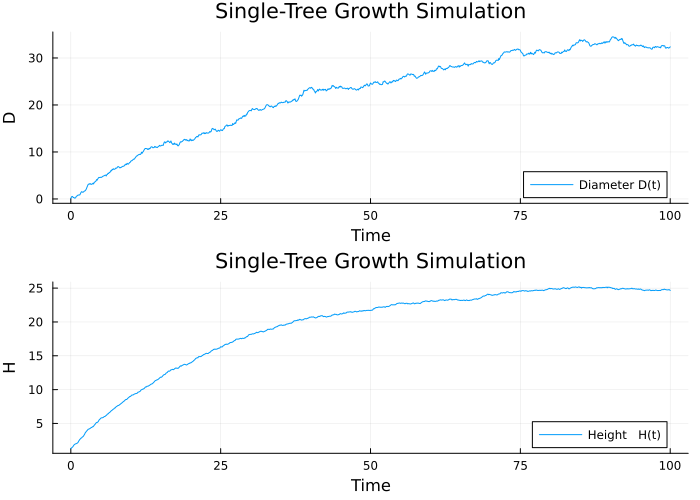

In [274]:
# 4. Initial condition at t0=5, below μ
Δt      = .1     # time step
T       = 1000     # number of steps
t0      = 5.0     # initial “age”
x0      = [0.1, 1.3]  # start (diameter, height) at t0

# 5. Allocate & initialize
Xs = Array{Float64}(undef, 2, T+1)
Xs[:,1] .= x0

# 5. Simulate forward from k=1..T
rng = MersenneTwister(39)
dist = MvNormal(zeros(2), Δt)
for k in 1:T
    η = rand(rng, dist)
    Xs[:,k+1] = Xs[:,k] + A(Xs[:,k])*Δt .+ Ch * η
end

# 6. Plot the single trajectory
t = 0:Δt:T*Δt

p1 = plot(t, Xs[1,:], label="Diameter D(t)", xlabel="Time", ylabel="D", legend=:bottomright)
p2 = plot(t, Xs[2,:], label="Height   H(t)", xlabel="Time", ylabel="H", legend=:bottomright)

plot(p1, p2, layout=(2,1), size=(700,500), title="Single‐Tree Growth Simulation")

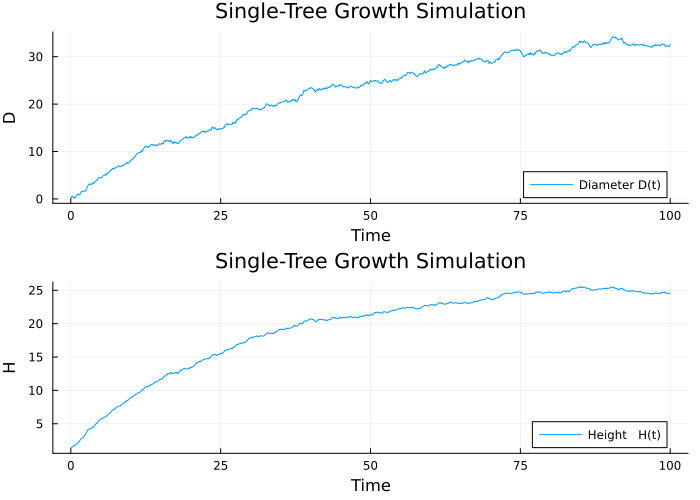

In [275]:
Ch_L = cholesky(B).L

# 4. Initial condition at t0=5, below μ
Δt      = .1     # time step
T       = 1000     # number of steps
t0      = 5.0     # initial “age”
x0      = [0.1, 1.3]  # start (diameter, height) at t0

# 5. Allocate & initialize
Xs = Array{Float64}(undef, 2, T+1)
Xs[:,1] .= x0

# 5. Simulate forward from k=1..T
rng = MersenneTwister(39)
dist = MvNormal(zeros(2), Δt)
for k in 1:T
    η = rand(rng, dist)
    Xs[:,k+1] = Xs[:,k] + A(Xs[:,k])*Δt .+ Ch_L * η
end

# 6. Plot the single trajectory
t = 0:Δt:T*Δt

p1 = plot(t, Xs[1,:], label="Diameter D(t)", xlabel="Time", ylabel="D", legend=:bottomright)
p2 = plot(t, Xs[2,:], label="Height   H(t)", xlabel="Time", ylabel="H", legend=:bottomright)

plot(p1, p2, layout=(2,1), size=(700,500), title="Single‐Tree Growth Simulation")

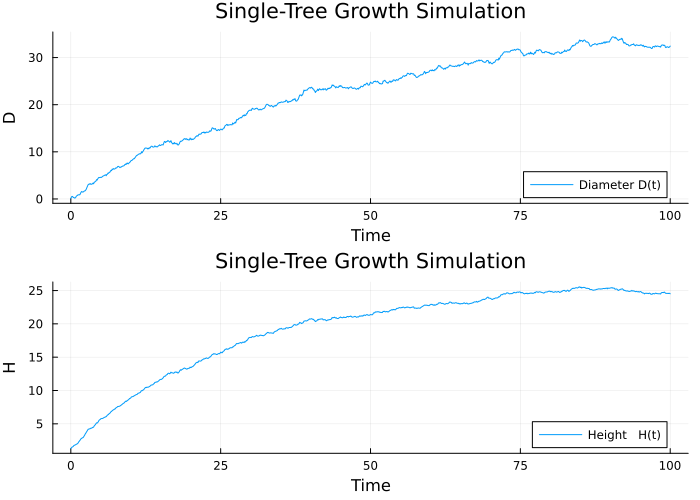

In [276]:
sqB = sqrt(B)

# 4. Initial condition at t0=5, below μ
Δt      = .1     # time step
T       = 1000     # number of steps
t0      = 5.0     # initial “age”
x0      = [0.1, 1.3]  # start (diameter, height) at t0

# 5. Allocate & initialize
Xs = Array{Float64}(undef, 2, T+1)
Xs[:,1] .= x0

# 5. Simulate forward from k=1..T
rng = MersenneTwister(39)
dist = MvNormal(zeros(2), Δt)
for k in 1:T
    η = rand(rng, dist)
    Xs[:,k+1] = Xs[:,k] + A(Xs[:,k])*Δt .+ sqB * η
end

# 6. Plot the single trajectory
t = 0:Δt:T*Δt

p1 = plot(t, Xs[1,:], label="Diameter D(t)", xlabel="Time", ylabel="D", legend=:bottomright)
p2 = plot(t, Xs[2,:], label="Height   H(t)", xlabel="Time", ylabel="H", legend=:bottomright)

plot(p1, p2, layout=(2,1), size=(700,500), title="Single‐Tree Growth Simulation")

In [277]:
# 5. Allocate & initialize
Xs_L = Array{Float64, 3}(undef, 2, T+1, samples)
X0 = reshape(repeat(x0, samples), (2, samples))
Xs_L[:,1,:] .= X0

# 5. Simulate forward from k=1..T
rng = MersenneTwister(39)
dist = MvNormal(zeros(2), Δt)
for k in 1:T
    for j in 1:samples
        η = rand(rng, dist)
        Xs_L[:,k+1,j] = Xs_L[:,k,j] + A(Xs_L[:,k,j])*Δt .+ Ch_L * η
    end
end

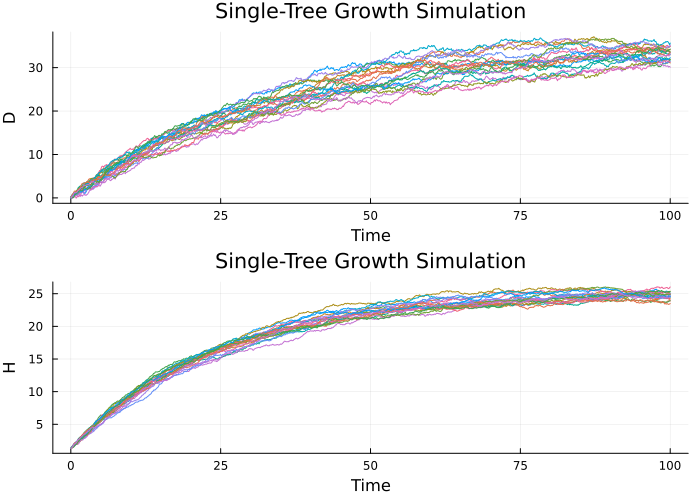

In [278]:
# 6. Plot the trajectories
t = 0:Δt:T*Δt
 
p1 = plot(t, Xs_L[1,:,1:20], xlabel="Time", ylabel="D", legend=false)
p2 = plot(t, Xs_L[2,:,1:20], xlabel="Time", ylabel="H", legend=false)
 
plot(p1, p2, layout=(2,1), size=(700,500), title="Single‐Tree Growth Simulation")

In [279]:
# 4. Initial condition at t0=5, below μ
Δt      = .1     # time step
T       = 1000    # number of steps
t0      = 5.0     # initial “age”
x0      = [0.1, 1.3]  # start (diameter, height) at t0
samples = 50000 # number of samples

# 5. Allocate & initialize
Xs_U = Array{Float64, 3}(undef, 2, T+1, samples)
X0 = reshape(repeat(x0, samples), (2, samples))
Xs_U[:,1,:] .= X0

# 5. Simulate forward from k=1..T
rng = MersenneTwister(39)
dist = MvNormal(zeros(2), Δt)
for k in 1:T
    for j in 1:samples
        η = rand(rng, dist)
        Xs_U[:,k+1,j] = Xs_U[:,k,j] + A(Xs_U[:,k,j])*Δt .+ Ch * η
    end
end

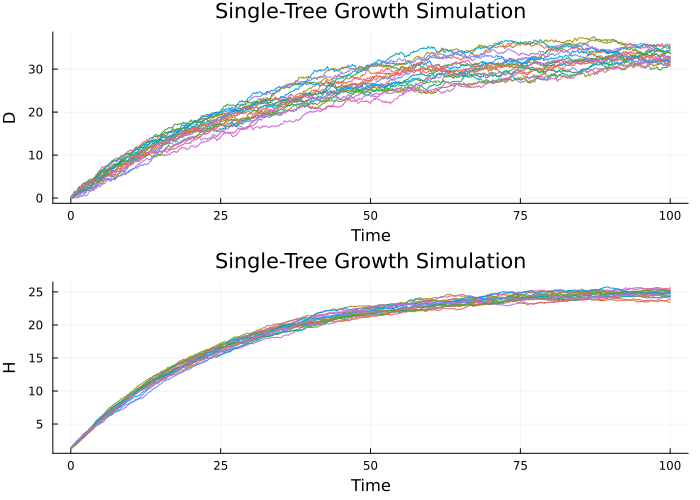

In [280]:
# 6. Plot the trajectories
t = 0:Δt:T*Δt

p1 = plot(t, Xs_U[1,:,1:20], xlabel="Time", ylabel="D", legend=false)
p2 = plot(t, Xs_U[2,:,1:20], xlabel="Time", ylabel="H", legend=false)
 
plot(p1, p2, layout=(2,1), size=(700,500), title="Single‐Tree Growth Simulation")

In [281]:
# 4. Initial condition at t0=5, below μ
Δt      = .1     # time step
T       = 1000    # number of steps
t0      = 5.0     # initial “age”
x0      = [0.1, 1.3]  # start (diameter, height) at t0
samples = 50000 # number of samples

# 5. Allocate & initialize
Xs = Array{Float64, 3}(undef, 2, T+1, samples)
X0 = reshape(repeat(x0, samples), (2, samples))
Xs[:,1,:] .= X0

# 5. Simulate forward from k=1..T
rng = MersenneTwister(39)
dist = MvNormal(zeros(2), Δt)
for k in 1:T
    for j in 1:samples
        η = rand(rng, dist)
        Xs[:,k+1,j] = Xs[:,k,j] + A(Xs[:,k,j])*Δt .+ sqB * η
    end
end

In [ ]:
# Write in terminal: Randomseed!(123);
 
num_walks = 50000;
num_steps = 1000;
 
# --- Data Generation ---
# Generate all steps at once for efficiency
 
steps = rand([-1, 1], num_steps, num_walks); # +1 or -1 for each step, each walk
# Cumulative sum to get positions (starting at 0)
 
walks = cumsum(steps, dims=1);
# Add the starting point (0,0) to each walk
 
walks = vcat(zeros(Int, 1, num_walks), walks); # shape (num_steps+1, num_walks)

# --- Plotting ---
# Use GR backend for speed: write in terminal: gr();
 
@time plot(
       # Plot each walk as a series
       [walks[:,i] for i in 1:num_walks], # Plotting individual series
       title="Thousands of Random Walks",
       xlabel="Time Step",
       ylabel="Position",
       lw=1,        # Line width
       alpha=0.1,   # Transparency for many lines
       legend=false # Hide legend if too many lines
)

823.987213 seconds (7.86 M allocations: 1.202 GiB, 0.96% gc time, 0.08% compilation time: 64% of which was recompilation)


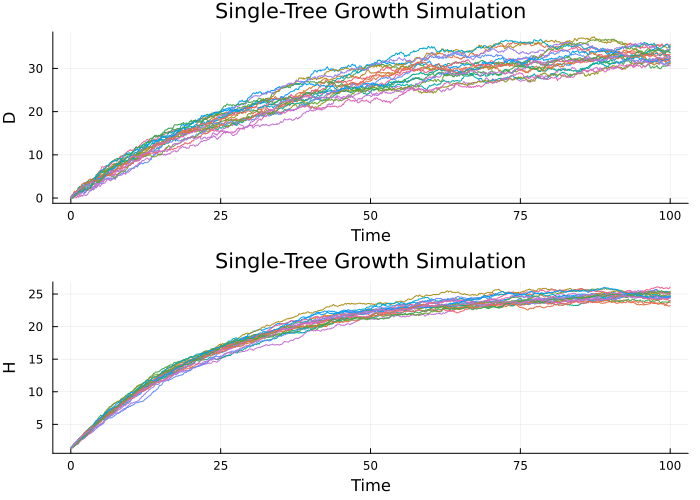

In [282]:
# 6. Plot the trajectories
t = 0:Δt:T*Δt
 
p1 = plot(t, Xs[1,:,1:20], xlabel="Time", ylabel="D", legend=false)
p2 = plot(t, Xs[2,:,1:20], xlabel="Time", ylabel="H", legend=false)
 
plot(p1, p2, layout=(2,1), size=(700,500), title="Single‐Tree Growth Simulation")

In [283]:
site_idx = mean(sort(Xs[2,400,:])[50000-100:50000])

22.447093611496598

## **''Markovianización'' del conjunto de estados**

Recuento del número de trayectorias

In [284]:
T_sim = floor(Int,T/50)
Ys = floor.(Int, round.(Int, Xs[:,1:50:end,:]) /5)

tr_dict = Dict()
for d1 in 0:8
    for d2 in 0:8
        for h1 in 0:6
            for h2 in 0:6
                tr_dict[[d1,h1],[d2,h2]] = 0
            end
        end
    end
end

for i in 1:samples
    for k in 1:T_sim
        tr_dict[Ys[:,k,i],Ys[:,k+1,i]] += 1
    end
end

sumas_mc = Dict()
valid_idx = []
for d1 in 0:8
    for h1 in 0:6
        s = sum(tr_dict[[d1,h1],[d2,h2]] for d2 in 0:8, h2 in 0:6)
        # omitir estados muy poco visitados
        if s >= 100 
            sumas_mc[[d1,h1]] = s
            push!(valid_idx, [d1,h1])
        end
    end
end

Matriz de transición

In [321]:
mc_dict = Dict()
for ik in valid_idx
    s = sumas_mc[ik]
    t = 0
    for jl in valid_idx
        mc_dict[ik,jl] = round(tr_dict[ik,jl]/s; digits = 2)
        if mc_dict[ik,jl] > 0
            print(ik)
            print(jl)
            println(mc_dict[ik,jl])
            t += mc_dict[ik,jl]
        end
    end
    println(t)
    println("----------")
end

[0, 0][0, 1]0.41
[0, 0][1, 1]0.58
0.99
----------
[0, 1][1, 1]0.83
[0, 1][1, 2]0.09
[0, 1][2, 1]0.04
[0, 1][2, 2]0.04
1.0
----------
[1, 1][1, 1]0.23
[1, 1][1, 2]0.08
[1, 1][2, 1]0.08
[1, 1][2, 2]0.6
0.99
----------
[1, 2][1, 2]0.01
[1, 2][2, 2]0.94
[1, 2][2, 3]0.03
[1, 2][3, 2]0.02
1.0
----------
[2, 1][2, 2]0.84
[2, 1][3, 2]0.16
1.0
----------
[2, 2][2, 2]0.27
[2, 2][2, 3]0.06
[2, 2][3, 2]0.21
[2, 2][3, 3]0.46
1.0
----------
[2, 3][2, 3]0.03
[2, 3][3, 3]0.96
0.99
----------
[3, 2][3, 2]0.03
[3, 2][3, 3]0.85
[3, 2][4, 3]0.12
1.0
----------
[3, 3][3, 3]0.42
[3, 3][4, 3]0.5
[3, 3][4, 4]0.08
0.9999999999999999
----------
[3, 4][3, 4]0.08
[3, 4][4, 4]0.92
1.0
----------
[4, 3][4, 3]0.37
[4, 3][4, 4]0.46
[4, 3][5, 3]0.01
[4, 3][5, 4]0.16
1.0
----------
[4, 4][4, 4]0.43
[4, 4][5, 4]0.57
1.0
----------
[5, 3][4, 3]0.01
[5, 3][4, 4]0.03
[5, 3][5, 3]0.03
[5, 3][5, 4]0.92
[5, 3][6, 4]0.01
1.0
----------
[5, 4][4, 4]0.01
[5, 4][5, 4]0.74
[5, 4][5, 5]0.01
[5, 4][6, 4]0.22
[5, 4][6, 5]0.03
1.01
--

# **Extensión del modelo Markovianizado**

## **Creación del modelo**

In [333]:
n = length(valid_idx)

x0_test = zeros(19)
x0_test[1] = 1
f_test = Float64[]
BAs = Float64[]
rel = Dict()
for i in 1:n
    push!(f_test, 1)
    i_d, i_h = valid_idx[i]
    rel[i] = [i_d, i_h]
    d_i = 5*i_d + 2.5
    push!(BAs, pi*d_i^2/40000) 
end

tr_mtx = zeros(n,n)
for i in 1:n
    for j in 1:n
        tr_mtx[i,j] = mc_dict[(rel[i],rel[j])]
    end
end

In [334]:
a0 = -3.552
a1 = -0.062 
a3 = 0.016

function p_rec(BA)
    return (1 + e^-(a0 + a3 + a1*BA))^-1
end

function dp_rec(BA)
    return a1 / (2*cosh(a0 + a3 + a1*BA) + 2)
end

b0 = 67.152
b1 = -0.076

function c_rec(BA)
    return b0 * BA^b1
end

function dc_rec(BA)
    return b0 * b1*BA^(b1-1)
end

dc_rec (generic function with 1 method)

In [335]:
new_model1 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0_test[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        [s = 2:n], x[s].out == sum((x[t].in - c[t])*tr_mtx[t,s] for t in 1:n) # Markovian transitions between set_attributes
        sum(f_test[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [k = 1:nx], u <= as1_x[k]*TV + bs1_x[k] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


In [336]:
new_model2 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0_test[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        [s = 2:n], x[s].out == sum((x[t].in - c[t])*tr_mtx[t,s] for t in 1:n) # Markovian transitions between set_attributes
        sum(f_test[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [k = 1:ny], u <= as1_y[k]*TV + bs1_y[k] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


In [337]:
new_model3 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0_test[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        [s = 2:n], x[s].out == sum((x[t].in - c[t])*tr_mtx[t,s] for t in 1:n) # Markovian transitions between set_attributes
        sum(f_test[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [k = 1:nx-1], u <= as2_x[k]*TV + bs2_x[k] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


In [291]:
new_model4 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0_test[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        [s = 2:n], x[s].out == sum((x[t].in - c[t])*tr_mtx[t,s] for t in 1:n) # Markovian transitions between set_attributes
        sum(f_test[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [k = 1:ny-1], u <= as2_y[k]*TV + bs2_y[k] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


In [338]:
SDDP.train(new_model1, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(new_model1, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(new_model1)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 19
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [60, 60]
  AffExpr in MOI.EqualTo{Float64}         : [20, 20]
  AffExpr in MOI.LessThan{Float64}        : [2519, 2519]
  VariableRef in MOI.GreaterThan{Float64} : [40, 40]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 1e+00]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     sol

In [293]:
SDDP.train(new_model2, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(new_model2, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(new_model2)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 19
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [60, 60]
  AffExpr in MOI.EqualTo{Float64}         : [20, 20]
  AffExpr in MOI.LessThan{Float64}        : [119, 119]
  VariableRef in MOI.GreaterThan{Float64} : [40, 40]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 2e+00]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [5e-01, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solve

In [294]:
SDDP.train(new_model3, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(new_model3, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(new_model3)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 19
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [60, 60]
  AffExpr in MOI.EqualTo{Float64}         : [20, 20]
  AffExpr in MOI.LessThan{Float64}        : [2518, 2518]
  VariableRef in MOI.GreaterThan{Float64} : [40, 40]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 1e+00]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     sol

In [295]:
SDDP.train(new_model4, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(new_model4, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(new_model4)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 19
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [60, 60]
  AffExpr in MOI.EqualTo{Float64}         : [20, 20]
  AffExpr in MOI.LessThan{Float64}        : [118, 118]
  VariableRef in MOI.GreaterThan{Float64} : [40, 40]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 1e+00]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [9e-01, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solve

# **Extensión del modelo con regeneración**

El modelo de regeneración a usar corresponde a aquel trabajado en Bollandsas et al, en el cual en cada etapa, el número de árboles de la especie $i\in\{1,\ldots, N\}$ de la primera clase de altura y diámetro corresponde al producto $\pi_i \times CR_i$, con 
- $\pi_i = \frac{e^{\alpha_{i0} + \alpha_{i1} BA + \alpha_{i2} SI + \alpha_{i3} PBA}}{1 + e^{\alpha_{i0} + \alpha_{i1} BA + \alpha_{i2} SI + \alpha_{i3} PBA}}$
- $CR_i = \beta_{i0} BA^{\beta_{i1}} SI^{\beta_{i2}} PBA^{\beta_{i3}}$

En particular, se asume que el área en la cual se trabaja es exactamente una hectárea, el site index SI corresponde a la altura promedio de los árboles dominantes de 40 años y el PBA es idéntico a 1 al existir una única especie.

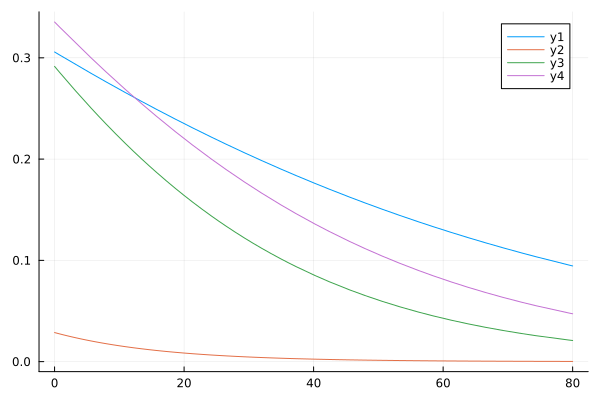

In [353]:
a_10, a_11, a_12, a_13 = (-2.291, -0.018, 0.066, 0.019)
a_20, a_21, a_22, a_23 = (-3.552, -0.062, 0, 0.031)
a_30, a_31, a_32, a_33 = (-0.904, -0.037, 0, 0.016)
a_40, a_41, a_42, a_43 = (-3.438, -0.029, 0.123, 0.048)

SI = 22 #DE JUGUETE

function pi_1(BA)
    return 1/(1 + exp(-(a_10 + a_11*BA + a_12*SI + a_13)))
end
function pi_2(BA)
    return 1/(1 + exp(-(a_20 + a_21*BA + a_22*SI + a_23)))
end
function pi_3(BA)
    return 1/(1 + exp(-(a_30 + a_31*BA + a_32*SI + a_33)))
end
function pi_4(BA)
    return 1/(1 + exp(-(a_40 + a_41*BA + a_42*SI + a_43)))
end

plot(pi_1, 0,80)
plot!(pi_2, 0,80)
plot!(pi_3, 0,80)
plot!(pi_4, 0,80)

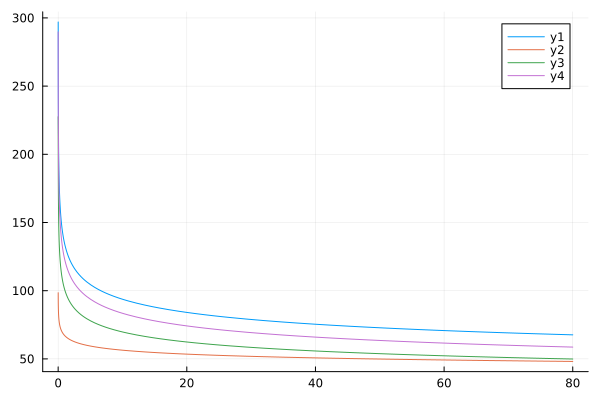

In [354]:
b_10, b_11, b_12 = (43.142, -0.157, 0.368)
b_20, b_21, b_22 = (67.152, -0.076, 0)
b_30, b_31, b_32 = (64.943, -0.161, 0.143)
b_40, b_41, b_42 = (31.438, -0.1695, 0.442)

SI = 22 #DE JUGUETE

function CR_1(BA)
    return b_10* BA^b_11 * SI^b_12
end
function CR_2(BA)
    return b_20* BA^b_21 * SI^b_22
end
function CR_3(BA)
    return b_30* BA^b_31 * SI^b_32
end
function CR_4(BA)
    return b_40* BA^b_41 * SI^b_42
end

plot(CR_1, 0,80)
plot!(CR_2, 0,80)
plot!(CR_3, 0,80)
plot!(CR_4, 0,80)

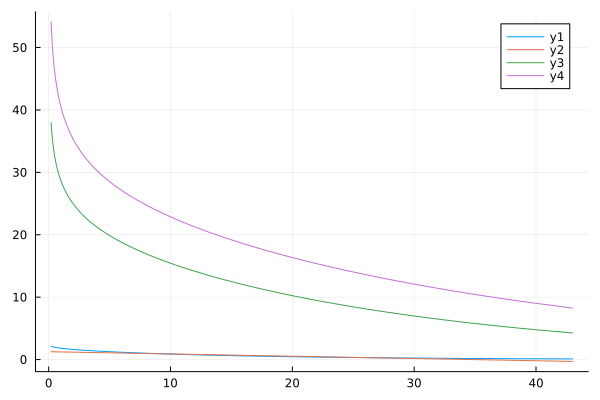

In [370]:
function d1(BA)
    return pi_1(BA)*CR_1(BA)
end

function d2(BA)
    return pi_2(BA)*CR_2(BA)
end

function d2_app(BA)
    x1, y1 = 5, d2(5)
    x2, y2 = 35, d2(35)
    return BA*(y2 - y1)/(x2 -x1) + y1
end

function d3(BA)
    return pi_3(BA)*CR_3(BA)
end

function d4(BA)
    return pi_4(BA)*CR_4(BA)
end
plot(d1, 0.2,43)
plot(d2, 0.2,43)
plot!(d2_app, 0.2, 43)
plot!(d3, 0.2,43)
plot!(d4, 0.2,43)

In [356]:
386*37.5^2*pi/40000

42.63239405691774

In [360]:
N_por_diam = 18.4/sum(d^2*pi/40000 for d in 2.5:5:37.5)

x0_reg = zeros(19)
x0_reg[1] = N_por_diam*7
UB = 1000

f_reg = Float64[]
for i in 1:n
    push!(f_reg, 0.01)
end

55.12378264265175

In [367]:
final_mode11 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0_reg[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, BA >= 0) # basal area
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        [s = 2:n], x[s].out == sum(tr_mtx[t,s]*(x[t].in - c[t]) for t in 1:n) # Markovian transitions between set_attributes
        sum(BAs[s] * x[s].out for s in 2:n) == BA # basal area
        sum(f_test[s] * c[s] for s in 1:n) == TV # timber volume
        x[1].out == d2_app(BA)
        [k = 1:ny-1], u <= as2_y[k]*TV + bs2_y[k] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


In [368]:
SDDP.train(final_mode11, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(final_mode11, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(final_mode11)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 19
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [61, 61]
  AffExpr in MOI.EqualTo{Float64}         : [21, 21]
  AffExpr in MOI.LessThan{Float64}        : [199, 199]
  VariableRef in MOI.GreaterThan{Float64} : [41, 41]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [5e-04, 1e+00]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [9e-01, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solve